In [ ]:

import re
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from transformers import pipeline
from collections import defaultdict
import numpy as np
from textblob import TextBlob
from pdfminer.high_level import extract_text
import os

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Caterina Grossi's notebook

In [2]:

# Load the NLP model for Named Entity Recognition (NER)
nlp = spacy.load("en_core_web_sm")

# Load the FinBERT model for sentiment analysis of financial text
finbert = pipeline("sentiment-analysis", model="ProsusAI/finbert")

# Define file paths for the 10-K reports to be analyzed
pdf_paths = [
    "/Users/caterinagrossi/Desktop/DataScience/Final_Project/IONQ 2021 10K.pdf",
    "/Users/caterinagrossi/Desktop/DataScience/Final_Project/IONQ 2022 10K.pdf",
    "/Users/caterinagrossi/Desktop/DataScience/Final_Project/IONQ 2023 10K.pdf",
    "/Users/caterinagrossi/Desktop/DataScience/Final_Project/IONQ 2024 10K.pdf"
]

# Function to extract and clean text from a 10-K PDF file
def extract_and_clean_text(pdf_path):
    """Extracts and cleans text from a 10-K PDF file."""
    print(f"Processing {os.path.basename(pdf_path)}...")

    # Extract text from PDF
    raw_text = extract_text(pdf_path)

    # Cleaning: Remove extra spaces, normalize newlines, and remove non-ASCII characters
    cleaned_text = re.sub(r"\s+", " ", raw_text)
    cleaned_text = re.sub(r"\n+", "\n", cleaned_text)
    cleaned_text = re.sub(r"[^\x00-\x7F]+", " ", cleaned_text)

    return cleaned_text.strip()

# Process all reports and save cleaned text
cleaned_texts = {}
for year, pdf in zip(["2021", "2022", "2023", "2024"], pdf_paths):
    cleaned_texts[year] = extract_and_clean_text(pdf)

    # Save cleaned text
    output_path = f"/Users/caterinagrossi/Desktop/DataScience/Final_Project/IONQ_{year}_Cleaned.txt"
    with open(output_path, "w", encoding="utf-8") as file:
        file.write(cleaned_texts[year])

print("All cleaned reports have been saved.")

# Define cleaned file paths
cleaned_files = {
    "2021": "/Users/caterinagrossi/Desktop/DataScience/Final_Project/IONQ_2021_Cleaned.txt",
    "2022": "/Users/caterinagrossi/Desktop/DataScience/Final_Project/IONQ_2022_Cleaned.txt",
    "2023": "/Users/caterinagrossi/Desktop/DataScience/Final_Project/IONQ_2023_Cleaned.txt",
    "2024": "/Users/caterinagrossi/Desktop/DataScience/Final_Project/IONQ_2024_Cleaned.txt"
}

# Read cleaned reports
cleaned_texts = {year: open(path, "r", encoding="utf-8").read() for year, path in cleaned_files.items()}

# Define a list of keywords related to partnerships and collaborations
partnership_keywords = [
    "partnership", "collaboration", "strategic alliance", "joint venture", 
    "business agreement", "teaming agreement", "subscription agreement", 
    "memorandum of understanding", "investment agreement", "alliance", "company agreement"
]


# Function to extract sentences mentioning partnerships
def extract_partnership_mentions(text):
    sentences = text.split(". ")
    return [sent for sent in sentences if any(keyword in sent.lower() for keyword in partnership_keywords)]

# Function to extract named entities (organizations) from the text
def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ == "ORG"]

# Function to perform sentiment analysis using FinBERT
def analyze_sentiment(sentences):
    if not sentences:
        return []
    
    batch_size = 5       # Process 5 sentences at a time to prevent API overload
    results = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        results.extend([res['label'] for res in finbert(batch)])

    return results

# Function to process all 10-K filings and extract relevant data
def process_10k_files(cleaned_texts):
    partnership_data = defaultdict(list)

    for year, text in cleaned_texts.items():
        print(f"Analyzing {year} 10-K...")

        # Extract partnership mentions
        partnership_sentences = extract_partnership_mentions(text)
        
        # Extract entities
        entities = extract_entities(" ".join(partnership_sentences))
        
        # Perform sentiment analysis
        sentiments = analyze_sentiment(partnership_sentences)

        for i, sentence in enumerate(partnership_sentences):
            partnership_data["Year"].append(year)
            partnership_data["Sentence"].append(sentence)
            partnership_data["Entities"].append(", ".join(set(entities)))
            partnership_data["Sentiment"].append(sentiments[i] if i < len(sentiments) else "Neutral")

    return pd.DataFrame(partnership_data)

# Execute the processing of 10-K reports and create a DataFrame
df = process_10k_files(cleaned_texts)

Device set to use mps:0


Processing IONQ 2021 10K.pdf...
Processing IONQ 2022 10K.pdf...
Processing IONQ 2023 10K.pdf...
Processing IONQ 2024 10K.pdf...
All cleaned reports have been saved.
Analyzing 2021 10-K...
Analyzing 2022 10-K...
Analyzing 2023 10-K...
Analyzing 2024 10-K...


In [3]:
df

,Year,Sentence,Entities,Sentiment
0,2021,We are not prohibited from pursuing an initial...,the Company s Current Report on Form 8-K (File...,neutral
1,2021,We expect to encounter competition from other ...,the Company s Current Report on Form 8-K (File...,neutral
2,2021,"On March 7, 2021, concurrently with the execut...",the Company s Current Report on Form 8-K (File...,neutral
3,2021,58 Table of Contents 10.5 10.6 10.7 10.8 10.9 ...,the Company s Current Report on Form 8-K (File...,neutral
4,2021,Form of Subscription Agreement (incorporated b...,the Company s Current Report on Form 8-K (File...,neutral
...,...,...,...,...
83,2024,Our operating results could be below the expec...,"Quantum, quantum algorithm development, Amazon...",negative
84,2024,A partnership exists between these aforementio...,"Quantum, quantum algorithm development, Amazon...",neutral
85,2024,Until such time as we can generate significant...,"Quantum, quantum algorithm development, Amazon...",neutral
86,2024,"If we raise funds through collaborations, or o...","Quantum, quantum algorithm development, Amazon...",negative


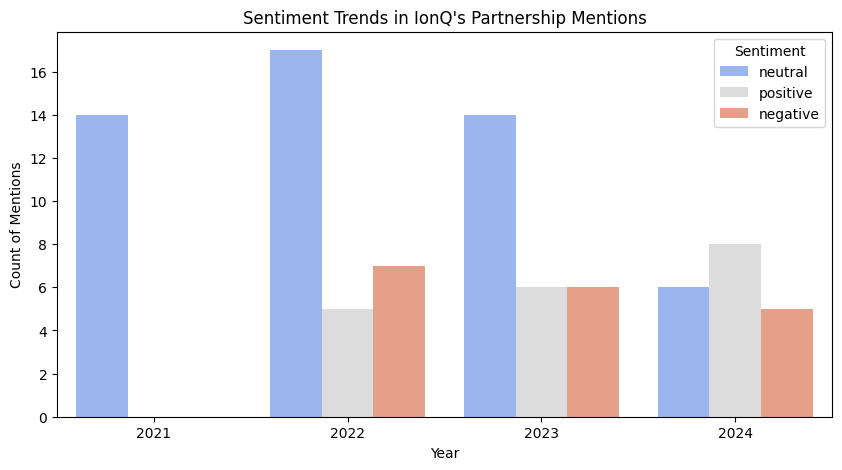

In [4]:

import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'Year' column to integer for proper sorting
df["Year"] = df["Year"].astype(int)

# Plot Sentiment Count by Year
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Year", hue="Sentiment", palette="coolwarm")
plt.title("Sentiment Trends in IonQ's Partnership Mentions")
plt.xlabel("Year")
plt.ylabel("Count of Mentions")
plt.legend(title="Sentiment")
plt.show()

<Figure size 1000x600 with 0 Axes>

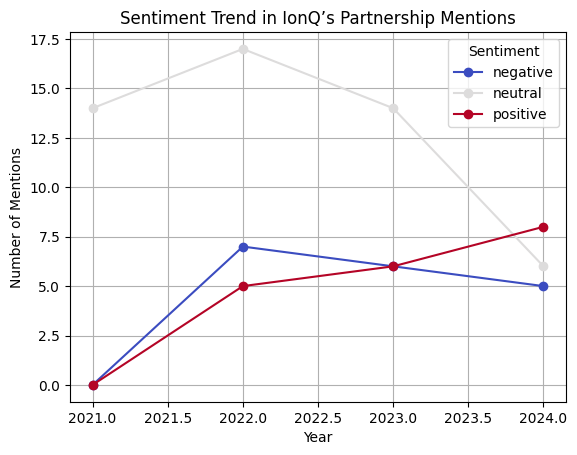

In [5]:
# Count sentiment occurrences per year
sentiment_trends = df.groupby(["Year", "Sentiment"]).size().unstack(fill_value=0)

# Plot sentiment trends
plt.figure(figsize=(10, 6))
sentiment_trends.plot(kind="line", marker="o", colormap="coolwarm")
plt.title("Sentiment Trend in IonQ’s Partnership Mentions")
plt.xlabel("Year")
plt.ylabel("Number of Mentions")
plt.legend(title="Sentiment")
plt.grid()
plt.show()

In [6]:
# Import necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

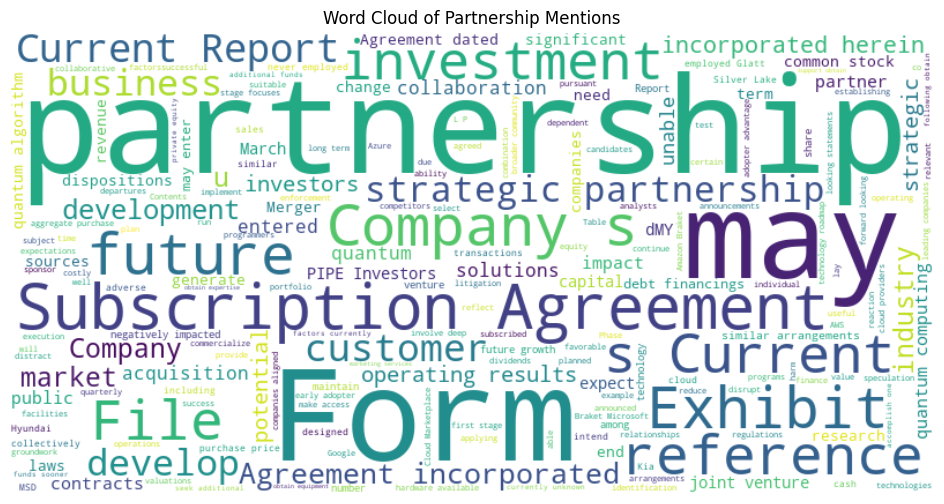

In [7]:
# Combine all partnership sentences
text_corpus = " ".join(df["Sentence"])

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_corpus)

# Plot Word Cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Partnership Mentions")
plt.show()

In [8]:
# List of uploaded files
file_paths = [
    "/Users/caterinagrossi/Desktop/DataScience/Final_Project/IONQ_2021_Cleaned.txt",
    "/Users/caterinagrossi/Desktop/DataScience/Final_Project/IONQ_2022_Cleaned.txt",
    "/Users/caterinagrossi/Desktop/DataScience/Final_Project/IONQ_2023_Cleaned.txt",
    "/Users/caterinagrossi/Desktop/DataScience/Final_Project/IONQ_2024_Cleaned.txt",
]

# Define the keywords for analysis
analysis_words = [
    "partnership", "collaboration", "strategic alliance", "joint venture", 
    "business agreement", "teaming agreement", "subscription agreement", 
    "memorandum of understanding", "investment agreement", "alliance", "company agreement"
]

# Initialize word counts
word_counts = {word: 0 for word in analysis_words}

# Process each file
for file_path in file_paths:
    with open(file_path, "r", encoding="utf-8") as file:
        text = file.read().lower()  # Convert text to lowercase for case-insensitive search

    # Count occurrences of each word
    for word in analysis_words:
        word_counts[word] += len(re.findall(rf"\b{re.escape(word)}\b", text))

# Convert results to DataFrame
word_counts_df = pd.DataFrame(word_counts.items(), columns=["Word", "Count"])
word_counts_df = word_counts_df.sort_values(by="Count", ascending=False)

In [9]:
word_counts_df

,Word,Count
6,subscription agreement,22
0,partnership,8
1,collaboration,3
3,joint venture,1
2,strategic alliance,0
4,business agreement,0
5,teaming agreement,0
7,memorandum of understanding,0
8,investment agreement,0
9,alliance,0


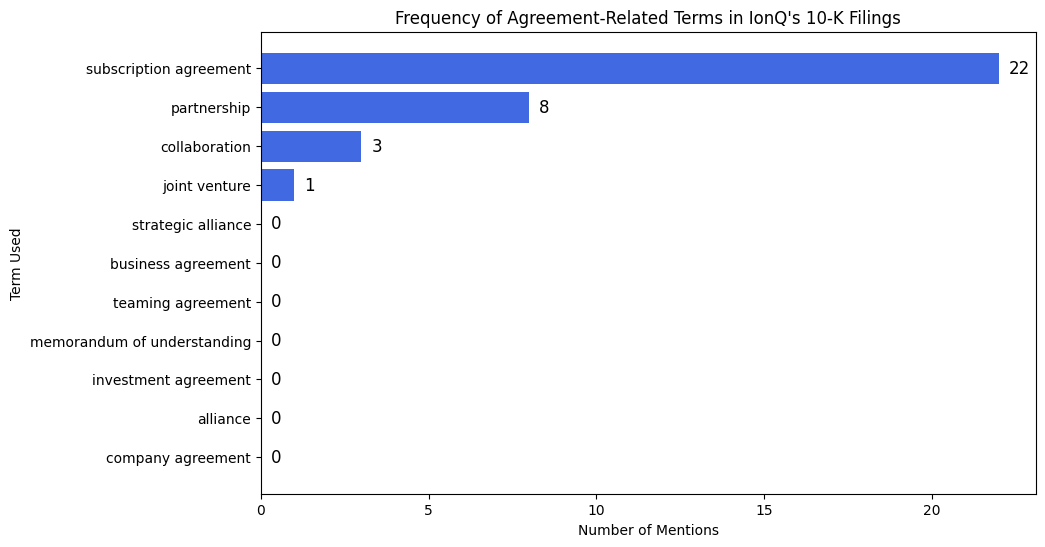

In [10]:
# Create the figure and bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(word_counts_df["Word"], word_counts_df["Count"], color='royalblue')

# Add count labels next to each bar
for bar in bars:
    plt.text(bar.get_width() +0.3 ,  # Position the text slightly to the right of the bar
             bar.get_y() + bar.get_height()/2,  # Center the text vertically
             str(int(bar.get_width())),  # Convert count to string
             va='center',  # Align text to center of bar
             fontsize=12)

# Labels and title
plt.xlabel("Number of Mentions")
plt.ylabel("Term Used")
plt.title("Frequency of Agreement-Related Terms in IonQ's 10-K Filings")
plt.gca().invert_yaxis()  # Invert y-axis for better readability

# Show the plot
plt.show()

In [11]:
# Import necessary libraries
from collections import Counter

In [12]:
# Load spaCy's large model for better accuracy
try:
# Load the NLP model for Named Entity Recognition (NER)
    nlp = spacy.load("en_core_web_trf")  # More accurate than "en_core_web_sm"
except:
# Load the NLP model for Named Entity Recognition (NER)
    nlp = spacy.load("en_core_web_sm")  # Fallback if large model isn't available

In [13]:
# List of uploaded files
file_paths = [
    "/Users/caterinagrossi/Desktop/DataScience/Final_Project/IONQ_2021_Cleaned.txt",
    "/Users/caterinagrossi/Desktop/DataScience/Final_Project/IONQ_2022_Cleaned.txt",
    "/Users/caterinagrossi/Desktop/DataScience/Final_Project/IONQ_2023_Cleaned.txt",
    "/Users/caterinagrossi/Desktop/DataScience/Final_Project/IONQ_2024_Cleaned.txt",
]

# Define agreement-related terms
agreement_terms = [
    "partnership", "collaboration", "strategic alliance", "joint venture", 
    "agreement", "memorandum of understanding", "research collaboration", "alliance"
]

# Define a regex pattern to match known company/university structures
company_pattern = r"\b([A-Z][A-Za-z0-9&\s-]+(?:Inc\.|Corp\.|Ltd\.|LLC|Company|Group|University|Institute|College))\b"

# Dictionary to store counts of mentioned companies/universities
entity_counts = Counter()

# Process each file
for file_path in file_paths:
    with open(file_path, "r", encoding="utf-8") as file:
        text = file.read()

    # Find sentences related to agreements
    sentences = re.findall(r"([^.]*?\b(?:{})\b[^.]*\.)".format("|".join(agreement_terms)), text, re.IGNORECASE)

    # Use spaCy NER to extract actual organizations and universities
    for sentence in sentences:
        doc = nlp(sentence)
        
        # Extract entities that are Organizations (ORG) or Universities (GPE)
        for ent in doc.ents:
            if ent.label_ in ["ORG", "GPE"]:  # ORG = Companies, GPE = Universities
                entity_counts[ent.text] += 1

        # Use regex backup for missed company/university names
        found_companies = re.findall(company_pattern, sentence)
        for company in set(found_companies):  
            entity_counts[company] += 1  # Avoid duplicate counts from the same sentence

# Convert results to DataFrame and sort
entity_df = pd.DataFrame(entity_counts.items(), columns=["Entity", "Count"])
entity_df = entity_df.sort_values(by="Count", ascending=False)

In [14]:
# Define keywords to distinguish between Companies/Universities and Agreement Types
company_keywords = {"university", "institute", "college", "inc", "corp", "llc", "group", "company", "firm"}
contract_keywords = {"agreement", "license", "merger", "contract", "understanding", "memorandum"}

# Separate entities into two categories
company_entities = []
contract_entities = []

for entity, count in entity_df.itertuples(index=False):
    words = entity.lower().split()
    
    # Check if it belongs to company/university or contract type
    if any(word in company_keywords for word in words):
        company_entities.append((entity, count))
    elif any(word in contract_keywords for word in words):
        contract_entities.append((entity, count))

# Convert to DataFrames
company_df = pd.DataFrame(company_entities, columns=["Entity", "Count"]).sort_values(by="Count", ascending=False)
contract_df = pd.DataFrame(contract_entities, columns=["Entity", "Count"]).sort_values(by="Count", ascending=False)

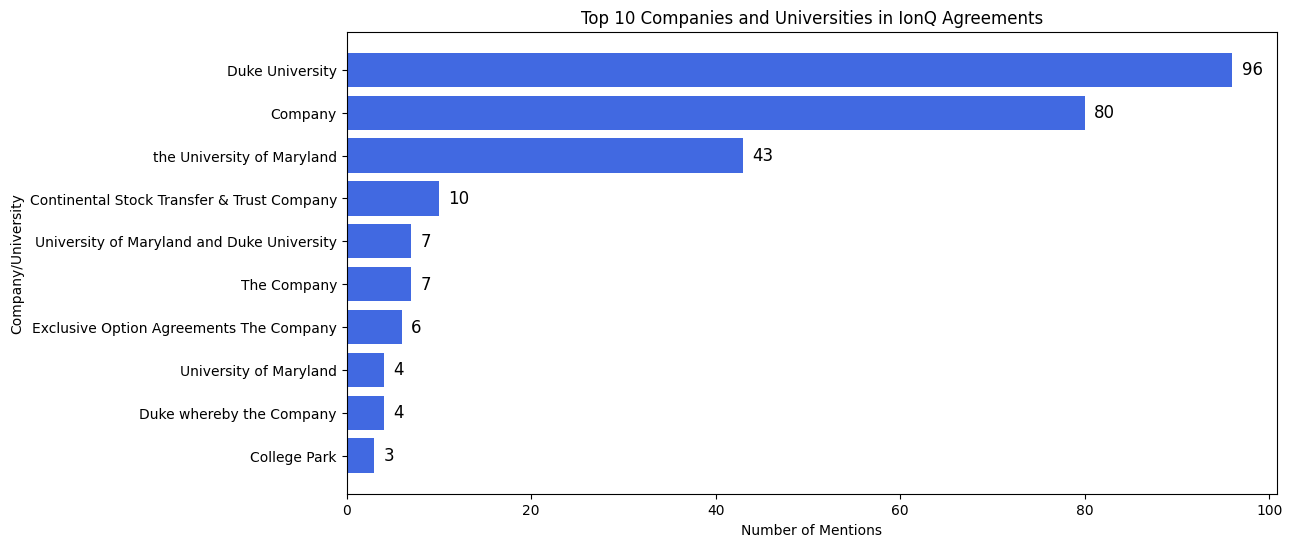

In [15]:
# Limit to top 10 entries for both categories
top_company_df = company_df.head(10)
top_contract_df = contract_df.head(10)

# Plot Top 10 Companies/Universities
if not top_company_df.empty:
    plt.figure(figsize=(12, 6))
    bars = plt.barh(top_company_df["Entity"], top_company_df["Count"], color="royalblue")
    for bar in bars:
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, str(int(bar.get_width())), va='center', fontsize=12)
    plt.xlabel("Number of Mentions")
    plt.ylabel("Company/University")
    plt.title("Top 10 Companies and Universities in IonQ Agreements")
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.show()

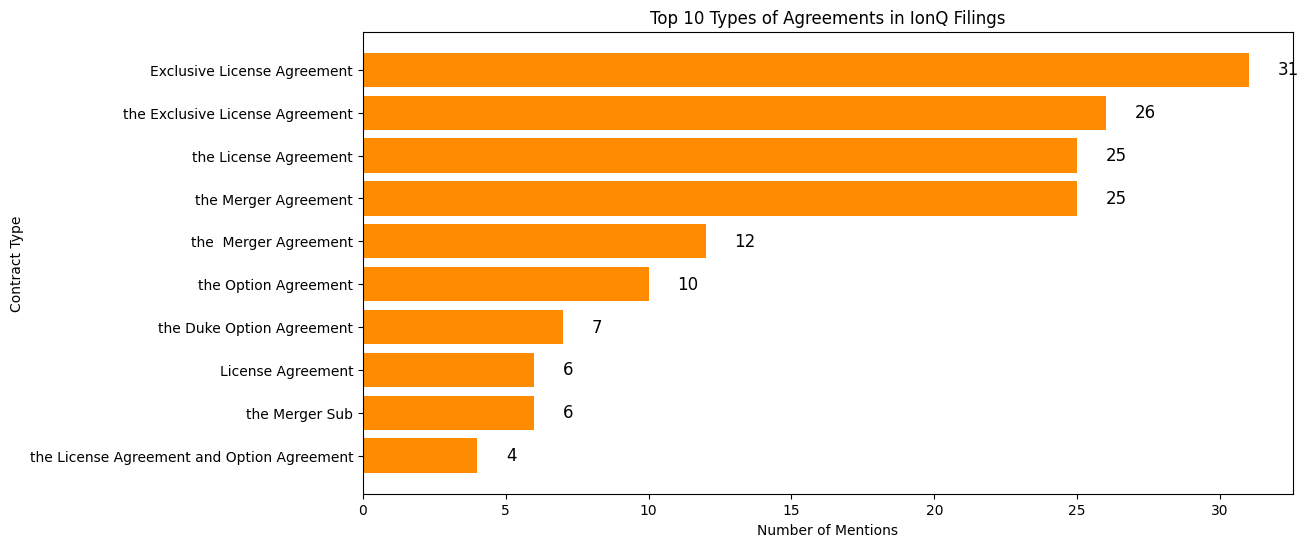

In [16]:
# Plot Top 10 Agreement Types
if not top_contract_df.empty:
    plt.figure(figsize=(12, 6))
    bars = plt.barh(top_contract_df["Entity"], top_contract_df["Count"], color="darkorange")
    for bar in bars:
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, str(int(bar.get_width())), va='center', fontsize=12)
    plt.xlabel("Number of Mentions")
    plt.ylabel("Contract Type")
    plt.title("Top 10 Types of Agreements in IonQ Filings")
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.show()

In [17]:
# Import necessary libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

In [18]:
# Import necessary libraries
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/caterinagrossi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
# Ensure NLTK stopwords are available
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/caterinagrossi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/caterinagrossi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:


# List of uploaded files
file_paths = [
    "/Users/caterinagrossi/Desktop/DataScience/Final_Project/IONQ_2021_Cleaned.txt",
    "/Users/caterinagrossi/Desktop/DataScience/Final_Project/IONQ_2022_Cleaned.txt",
    "/Users/caterinagrossi/Desktop/DataScience/Final_Project/IONQ_2023_Cleaned.txt",
    "/Users/caterinagrossi/Desktop/DataScience/Final_Project/IONQ_2024_Cleaned.txt",
]


In [21]:
# Define keywords related to finalizing agreements
deal_keywords = ["agreement", "contract", "deal", "sign", "partnership", "collaboration", "memorandum", "MOU", "engagement",
                 "commitment", "affiliation", "arrangement", "alliance"]

# Stopwords to remove common words
stop_words = set(stopwords.words('english'))

# Counter for word frequency
word_freq = Counter()

# Process each file
for file_path in file_paths:
    with open(file_path, "r", encoding="utf-8") as file:
        text = file.read().lower()  # Convert to lowercase for uniformity

    # Find sentences mentioning deals or final agreements
    sentences = re.findall(r"([^.]*?\b(?:{})\b[^.]*\.)".format("|".join(deal_keywords)), text, re.IGNORECASE)

    # Tokenize and filter words
    for sentence in sentences:
        words = word_tokenize(sentence)
        filtered_words = [word for word in words if word.isalpha() and word not in stop_words]
        word_freq.update(filtered_words)

In [22]:
# Convert to DataFrame and sort by frequency
word_freq_df = pd.DataFrame(word_freq.items(), columns=["Word", "Count"]).sort_values(by="Count", ascending=False).head(20)

In [23]:
word_freq_df

,Word,Count
3,agreement,642
1,company,213
944,license,203
965,option,200
240,stock,188
943,duke,153
28,shares,146
312,contract,136
239,common,126
241,warrant,125


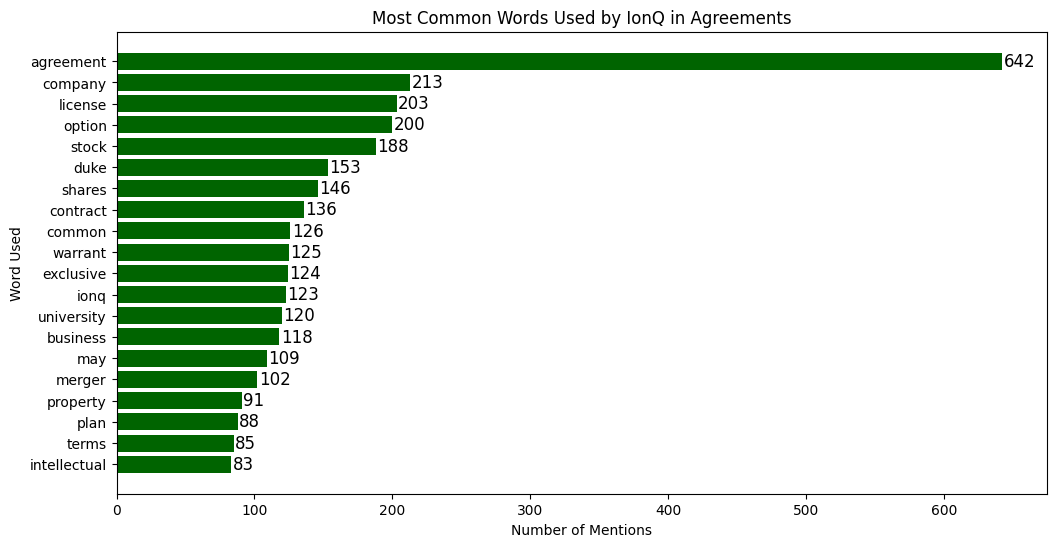

In [24]:
# Plot the most common words used in agreements
plt.figure(figsize=(12, 6))
bars = plt.barh(word_freq_df["Word"], word_freq_df["Count"], color="darkgreen")
for bar in bars:
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, str(int(bar.get_width())), va='center', fontsize=12)
plt.xlabel("Number of Mentions")
plt.ylabel("Word Used")
plt.title("Most Common Words Used by IonQ in Agreements")
plt.gca().invert_yaxis()
plt.show()

In [25]:
# Display the DataFrame using Pandas
print(word_freq_df.head(20))  # Show the top 20 words

             Word  Count
3       agreement    642
1         company    213
944       license    203
965        option    200
240         stock    188
943          duke    153
28         shares    146
312      contract    136
239        common    126
241       warrant    125
394     exclusive    124
506          ionq    123
941    university    120
35       business    118
30            may    109
5          merger    102
848      property     91
4            plan     88
230         terms     85
952  intellectual     83
